In [140]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
tf.enable_eager_execution()

from sklearn import svm
from sklearn.svm import SVR
from sklearn import metrics

from scipy import stats
from datetime import datetime

from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

import os.path

mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.grid'] = False

Variable initalizations to be used later

In [141]:
tf.random.set_random_seed(13)
BATCH_SIZE = 256
BUFFER_SIZE = 10000
STEP = 1

The file containing the airport weather data is read in, skipping rows which contain unneeded information

In [208]:
dubAirUrl = 'https://raw.githubusercontent.com/MatthewBarrettUCD/Final-Year-Project/master/hly532.csv'
dubAirWD = pd.read_csv(dubAirUrl, skiprows = 22)
dubAirWD.columns = dubAirWD.iloc[0]
dubAirWD = dubAirWD.drop(dubAirWD.index[0])

C:\Users\Matthew\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The CSV containing the UCD Veterinary Building Data is then read in. The data is prepared into a usable format for the models.

NOTE: This data is available upon request, placeholder data will be generated if it is not present. This will affect the accuracy of the models as no correlation will exist with the weather data.

In [209]:
if os.path.isfile('UCD_Belfield_Veterinary Science.csv'):
    ucdBD = pd.read_csv('UCD_Belfield_Veterinary Science.csv', skiprows = 1)
    ucdBD.drop(['Values'], axis = 1, inplace = True)

    ucdBD = ucdBD.stack().reset_index()
    ucdBD.drop(['level_0'], axis = 1, inplace = True)
else:
    placeholderUrl = 'https://raw.githubusercontent.com/MatthewBarrettUCD/Final-Year-Project/master/placeholder_data.csv'
    ucdBD = pd.read_csv(placeholderUrl)
    ucdBD['Usage'] = np.random.randint(30,150, size=len(ucdBD))
    placeholder = True

In [144]:
if not placeholder:
    dateTemp = 0
    countBool = False
    x = 0

    while x < (len(ucdBD)):
        if countBool:
            countBool = False
            x -= 1

        if ucdBD.iloc[x,0] == "Date":
            ucdBD.iloc[x,0] = ucdBD.iloc[x,1]
            dateTemp = ucdBD.iloc[x,1]
            ucdBD = ucdBD.drop(ucdBD.index[x])
            countBool = True
        else:
            ucdBD.iloc[x,0] = str(dateTemp) + " " + ucdBD.iloc[x,0]

        x += 1

In [160]:
if not placeholder:
    ucdBD.columns = ['Date', 'Usage']

ucdBD.index = ucdBD['Date']
ucdBD.drop(['Date'], axis = 1, inplace = True)

In [146]:
if not placeholder:
    ucdBD.index = pd.to_datetime(ucdBD.index, utc = True)
    ucdBD = ucdBD.astype(float).resample('60min').mean()

ucdBD

In [147]:
if "ind" in dubAirWD.columns:
    dubAirWD.drop(['ind'], axis = 1, inplace = True)

In [148]:
dubAirWD.index = dubAirWD['date']
dubAirWD.drop(['date'], axis = 1, inplace = True)

In [149]:
dubAirWD.index = pd.to_datetime(dubAirWD.index, utc = True)
dubAirWD

,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
date,,,,,,,,,,,,,,,
1990-01-01 00:00:00+00:00,0.1,9,8.1,7.1,10.1,88,1008.3,10,140,50,52,0,7000,7,8
1990-01-01 01:00:00+00:00,0,8.9,8,7,10,88,1007.7,12,140,50,52,0,7000,7,8
1990-01-01 02:00:00+00:00,0,8.8,7.9,6.9,9.9,88,1007.1,14,150,20,52,0,5000,7,8
1990-01-01 03:00:00+00:00,0,9,8.1,7.1,10.1,88,1007.1,17,160,50,52,0,6000,7,8
1990-01-01 04:00:00+00:00,0.6,9,8.4,7.8,10.5,92,1007.1,15,160,60,65,0,9000,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:00:00+00:00,0,6.9,4.6,1.2,6.6,67,1033.6,8,360,2,11,0,30000,40,7
2020-03-31 21:00:00+00:00,0,6.7,4.4,1,6.5,67,1033.2,9,360,2,11,0,30000,40,7
2020-03-31 22:00:00+00:00,0,6.8,4.3,0.4,6.3,64,1032.7,7,350,2,11,0,30000,40,7


In [162]:
uawdf = pd.merge(ucdBD,dubAirWD, left_index = True, right_index = True)

for z in uawdf.columns:
    uawdf[z] = pd.to_numeric(uawdf[z], errors = 'coerce')
    
for z in uawdf.columns:
    if uawdf[z].isna().any() == True:
        uawdf[z] = uawdf[z].interpolate()

The data will be split with a ratio of 80:20 into training and test data. Additional temporal features such as dayOfTheWeek and hourOfTheDay are added for each hour.

In [164]:
TRAIN_SPLIT = int(len(uawdf)*0.8)

In [166]:
def getHour(dayx):
    return dayx.hour

In [167]:
uawdf['dayOfTheWeek'] = uawdf.index
uawdf['dayOfTheWeek'] = uawdf['dayOfTheWeek'].apply(datetime.weekday)

uawdf['hourOfTheDay'] = uawdf.index
uawdf['hourOfTheDay'] = uawdf['hourOfTheDay'].apply(getHour)

In [168]:
uawdf.columns

Index(['Usage', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl',
       'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt',
       'dayOfTheWeek', 'hourOfTheDay'],
      dtype='object')

We then normalize the dataset and use a pairwise correlation to find which features have the greatest correlation with the independent variable to be predicted, the building energy usage (Usage).

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F59F263688>,
      dtype=object)

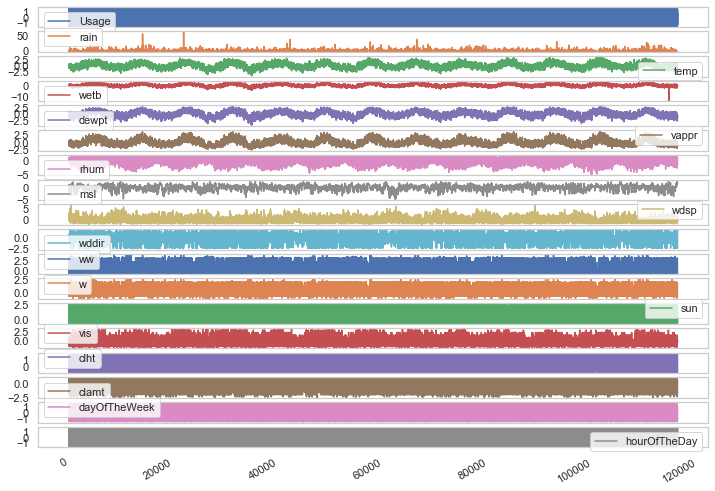

In [170]:
uawdf_features_considered = ['Usage', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl','wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt','dayOfTheWeek', 'hourOfTheDay']

uawdf_features = uawdf[uawdf_features_considered]
uawdf_features.index = uawdf.index

uawdf_dataset = np.zeros(shape=(0,0))

uawdf_dataset = uawdf_features.values
uawdf_data_mean = np.nanmean(uawdf_dataset[:TRAIN_SPLIT],axis=0)
uawdf_data_std = np.nanstd(uawdf_dataset[:TRAIN_SPLIT],axis=0)

uawdf_dataset = (uawdf_dataset-uawdf_data_mean)/uawdf_data_std

uawdf_datasetdf = pd.DataFrame(uawdf_dataset, columns = ['Usage', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl',
       'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt',
       'dayOfTheWeek', 'hourOfTheDay'])

ucdUsageDataMaster = uawdf_datasetdf.copy()

uawdf_datasetdf.plot(subplots=True)

In [171]:
uawdf_datasetdf.corr()

,Usage,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt,dayOfTheWeek,hourOfTheDay
Usage,1.000000,0.000415,0.006950,0.006745,0.006497,0.006333,-0.002601,-0.001508,0.000395,-0.003241,-0.003817,-0.000069,0.005783,0.004041,-0.001712,0.001124,-0.002087,-0.000118
rain,0.000415,1.000000,0.004599,0.045207,0.090271,0.092219,0.175927,-0.179504,0.064490,-0.068441,0.402438,0.295012,-0.088512,-0.232875,-0.130156,0.173254,-0.006666,0.006869
temp,0.006950,0.004599,1.000000,0.977001,0.886011,0.870860,-0.426251,0.062755,0.049441,-0.108291,-0.007000,0.023911,0.264197,0.211273,-0.217772,0.216857,-0.001434,0.151965
wetb,0.006745,0.045207,0.977001,1.000000,0.961818,0.947577,-0.231906,0.039383,0.015846,-0.110648,0.059939,0.076119,0.162176,0.095436,-0.254788,0.266776,-0.003993,0.106568
dewpt,0.006497,0.090271,0.886011,0.961818,1.000000,0.987423,0.037444,0.009307,-0.037925,-0.101243,0.136620,0.131303,0.025228,-0.056773,-0.277523,0.303580,-0.007054,0.039975
vappr,0.006333,0.092219,0.870860,0.947577,0.987423,1.000000,0.046663,0.011313,-0.047065,-0.101864,0.137702,0.131559,0.022486,-0.065388,-0.265189,0.289961,-0.007967,0.039654
rhum,-0.002601,0.175927,-0.426251,-0.231906,0.037444,0.046663,1.000000,-0.110360,-0.204268,0.036565,0.291202,0.204605,-0.506970,-0.576292,-0.061581,0.114674,-0.009986,-0.259036
msl,-0.001508,-0.179504,0.062755,0.039383,0.009307,0.011313,-0.110360,1.000000,-0.341293,-0.017285,-0.292570,-0.341892,0.096544,0.150378,0.127968,-0.148536,-0.002445,0.002885
wdsp,0.000395,0.064490,0.049441,0.015846,-0.037925,-0.047065,-0.204268,-0.341293,1.000000,0.107488,0.198340,0.264918,0.073607,-0.035593,-0.121388,0.125674,0.024864,0.054385
wddir,-0.003241,-0.068441,-0.108291,-0.110648,-0.101243,-0.101864,0.036565,-0.017285,0.107488,1.000000,-0.064298,0.002352,-0.026961,0.170775,0.042792,-0.073929,0.010532,-0.042333


In [172]:
sortedFeatures = uawdf_datasetdf.corr()['Usage'].abs().sort_values(ascending = False)
sortedFeatures

Usage           1.000000
temp            0.006950
wetb            0.006745
dewpt           0.006497
vappr           0.006333
sun             0.005783
vis             0.004041
ww              0.003817
wddir           0.003241
rhum            0.002601
dayOfTheWeek    0.002087
clht            0.001712
msl             0.001508
clamt           0.001124
rain            0.000415
wdsp            0.000395
hourOfTheDay    0.000118
w               0.000069
Name: Usage, dtype: float64

In [174]:
dates = np.arange(0,1568)

ucdUsageData = ucdUsageDataMaster.copy()

ucdUsageData.columns

Index(['Usage', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl',
       'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt',
       'dayOfTheWeek', 'hourOfTheDay'],
      dtype='object')

In [175]:
ucdUsageData['Usage24Ahead'] = ucdUsageData['Usage'].shift(-24)
ucdUsageData = ucdUsageData.dropna()
bestFeatures = []

for x in range(len(sortedFeatures)):
    if x > 5:
        ucdUsageData.drop([sortedFeatures.index[x]], axis = 1, inplace = True)
    else:
        bestFeatures.append(sortedFeatures.index[x])
        
ucdUsageData.columns

Index(['Usage', 'temp', 'wetb', 'dewpt', 'vappr', 'sun', 'Usage24Ahead'], dtype='object')

Sorted by highest correlation with Usage, the best features are found to be sun, rhum (humidity), dayOfTheWeek, wdsp (windspeed) and temp (temperature)

In [176]:
bestFeatures

['Usage', 'temp', 'wetb', 'dewpt', 'vappr', 'sun']

# Support Vector Machine

We train the SVM using these features as the dependent variables and the Usage 24 hours ahead as the independent variable to be predicted

In [178]:
ucd_X_svm = np.array(ucdUsageData[bestFeatures])
ucd_y_svm = np.array(ucdUsageData['Usage24Ahead'])

In [179]:
from sklearn.model_selection import train_test_split
ucd_X_train_svm, ucd_X_test_svm, ucd_y_train_svm, ucd_y_test_svm = train_test_split(ucd_X_svm, ucd_y_svm, test_size = 0.2, random_state = 42)

In [180]:
svm_past_history = 24
svm_future_target = 24
svm_STEP = 1

In [181]:
ucdUsageData.drop(['Usage24Ahead'], axis = 1, inplace = True)

In [182]:
ucdUsageDataArray = np.array(ucdUsageData)

In [183]:
def multivariate_data_no_shift(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [184]:
ucd_svm_x_train, ucd_svm_y_train = multivariate_data_no_shift(ucdUsageDataArray[:,0:6], ucdUsageDataArray[:, 0], 0,
                                                   TRAIN_SPLIT, svm_past_history,
                                                   svm_future_target, svm_STEP)
ucd_svm_x_val, ucd_svm_y_val = multivariate_data_no_shift(ucdUsageDataArray[:,0:6], ucdUsageDataArray[:, 0],
                                               TRAIN_SPLIT, None, svm_past_history,
                                               svm_future_target, svm_STEP)

print ('Single window of past history : {}'.format(ucd_svm_x_train[0].shape))

Single window of past history : (24, 6)


In [185]:
ucd_train_data_svm = tf.data.Dataset.from_tensor_slices((ucd_svm_x_train, ucd_svm_y_train))
ucd_train_data_svm = ucd_train_data_svm.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

ucd_val_data_svm = tf.data.Dataset.from_tensor_slices((ucd_svm_x_val, ucd_svm_y_val))
ucd_val_data_svm = ucd_val_data_svm.batch(BATCH_SIZE).repeat()

We fit the SVR and then plot one 24 hour period

In [186]:
ucd_reg_svr = SVR()
ucd_reg_svr.fit(ucd_X_train_svm, ucd_y_train_svm)
ucd_y_pred_svm = ucd_reg_svr.predict(ucd_svm_x_val[1020])

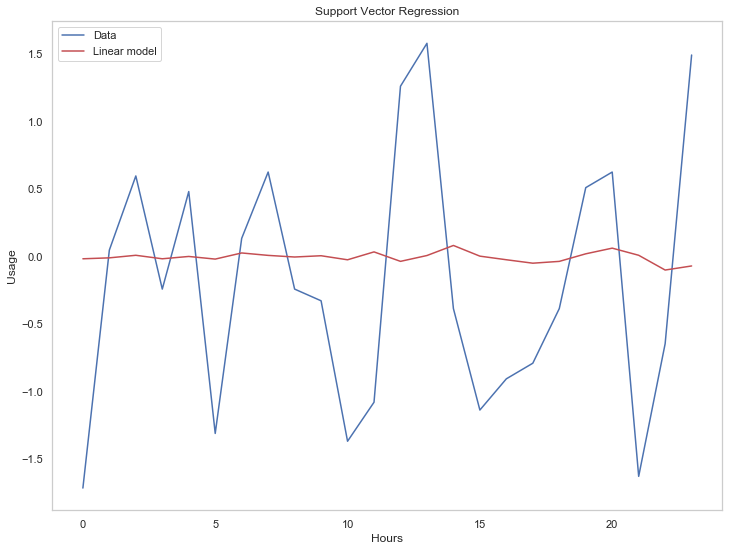

In [187]:
dates = np.arange(0,24)
    
plt.plot(dates, (ucd_svm_y_val[1020]), c='b', label='Data')
plt.plot(dates, ucd_y_pred_svm, c='r', label='Linear model')
    
plt.xlabel('Hours')
plt.ylabel('Usage')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [188]:
ucd_full_pred = ucd_reg_svr.predict(ucd_X_test_svm)

Next we plot 100 hours of prediction

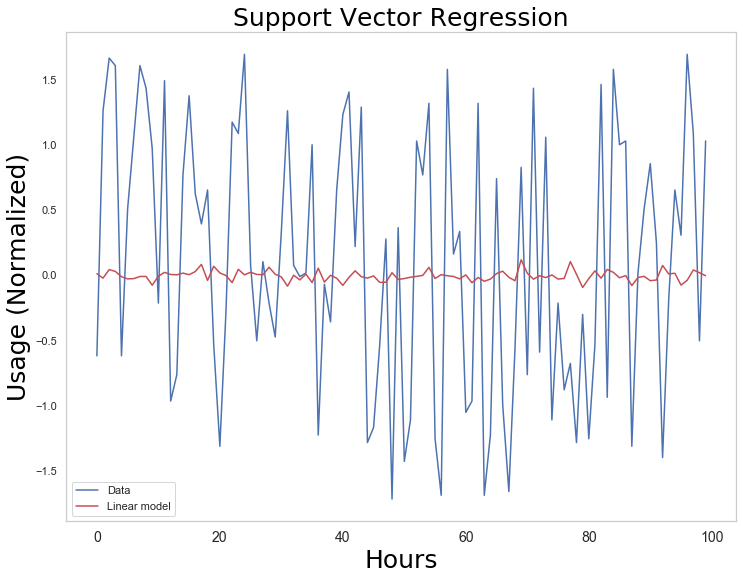

In [189]:
dates = np.arange(0,100)
  
font = {'family': 'DejaVu Sans',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }

plt.plot(dates, ucd_y_test_svm[:100], c='b', label='Data')
plt.plot(dates, ucd_full_pred[:100], c='r', label='Linear model')

plt.xticks(fontsize=14)
plt.xlabel('Hours',fontdict=font)
plt.ylabel('Usage (Normalized)',fontdict=font)
plt.title('Support Vector Regression',fontdict=font)
plt.legend()
plt.show()

We then make a batch of 256 predictions

In [190]:
ucd_svm_comp_pred = []

for z in range(2560):
    ucd_svm_comp_pred.append(ucd_reg_svr.predict(ucd_svm_x_val[z]))

# RNN - 24 Hour Training Window

In [191]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b', label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r', label='Predicted Future')
    
    plt.legend(loc='upper left')
    plt.show()

def create_time_steps(length):
  return list(range(-length, 0))

def plot_train_history(history, title, rmse = False):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mse = history.history['mean_squared_error']
    if rmse:
        rmse = history.history['root_mean_squared_error']
        val_rmse = history.history['val_root_mean_squared_error']
    
    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.plot(epochs, mse, 'y', label='Mean Squared Error')
    if rmse:
        plt.plot(epochs, rmse, 'g', label='Root Mean Squared Error')
        plt.plot(epochs, val_rmse, 'm', label='Validation Root Mean Squared Error')
    plt.title(title)
    plt.legend()

    plt.show()

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Here we segment the data into 24 hour periods to train the RNN

In [192]:
mvms_past_history = 24
mvms_future_target = 24
mvms_STEP = 1

x_train_multi, y_train_multi = multivariate_data(ucdUsageDataArray, ucdUsageDataArray[:, 0], 0,
                                                 TRAIN_SPLIT, mvms_past_history,
                                                 mvms_future_target, mvms_STEP)
x_val_multi, y_val_multi = multivariate_data(ucdUsageDataArray, ucdUsageDataArray[:, 0],
                                             TRAIN_SPLIT, None, mvms_past_history,
                                             mvms_future_target, mvms_STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target usage to predict : {}'.format(y_train_multi[0].shape))

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Single window of past history : (24, 6)

 Target usage to predict : (24,)


## Model Design

Here we layout the model and select the hyperparameters

(256, 24)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 54s 269ms/step - loss: 0.8670 - mean_squared_error: 1.0007 - root_mean_squared_error: 1.0003 - val_loss: 0.8709 - val_mean_squared_error: 1.0118 - val_root_mean_squared_error: 1.0055
Epoch 2/10
200/200 [==============================] - 32s 161ms/step - loss: 0.8664 - mean_squared_error: 1.0009 - root_mean_squared_error: 1.0004 - val_loss: 0.8709 - val_mean_squared_error: 1.0119 - val_root_mean_squared_error: 1.0056
Epoch 3/10
200/200 [==============================] - 32s 159ms/step - loss: 0.8662 - mean_squared_error: 0.9997 - root_mean_squared_error: 0.9998 - val_loss: 0.8709 - val_mean_squared_error: 1.0120 - val_root_mean_squared_error: 1.0056
Epoch 4/10
200/200 [==============================] - 33s 163ms/step - loss: 0.8666 - mean_squared_error: 1.0006 - root_mean_squared_error: 1.0003 - val_loss: 0.8709 - val_mean_squared_error: 1.0120 - val_root_mean_squared_error: 1.0056

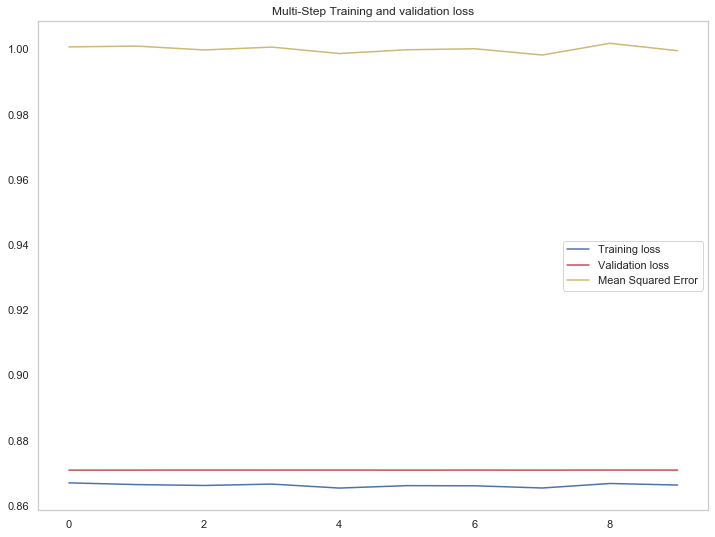

In [193]:
multi_step_model = tf.keras.models.Sequential()

multi_step_model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

multi_step_model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

multi_step_model.add(tf.keras.layers.LSTM(200, activation='relu',return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(25, activation='relu'))

multi_step_model.add(tf.keras.layers.Dropout(rate=0.3))

multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mean_squared_error',
                                                                                                    root_mean_squared_error])

for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

multi_step_history = multi_step_model.fit(train_data_multi, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

We then make our predictions using the model

In [194]:
rnn_data = []
rnn_comp_pred = []
ucd_svr_comp_pred = []
    
for x, y in val_data_multi.take(10):
    for a in range(len(x)):
        rnn_data.append(y[a])
        ucd_svr_comp_pred.append(ucd_reg_svr.predict(x[a]))
        rnn_comp_pred.append(multi_step_model.predict(x)[a])

In [195]:
def get30days(mainArray):
    firstBool = False
    d30a = np.array([])
    
    for x in range(30):
        if firstBool == False:
            d30a = np.concatenate((mainArray[int(24*x)], mainArray[int(24*(x+1))]), axis = 0)
            firstBool = True
        else:
            d30a = np.concatenate((d30a, mainArray[int(24*(x+1))]), axis = 0)
    
    return d30a

In [196]:
rnn_data_30 = get30days(rnn_data)
rnn_pred_30 = get30days(rnn_comp_pred)
svr_pred_30 = get30days(ucd_svr_comp_pred)

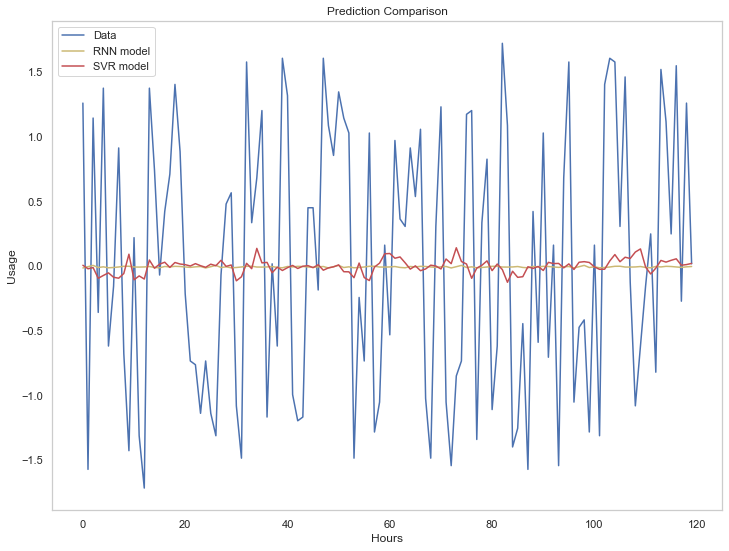

In [197]:
dates = np.arange(0,len(rnn_data_30[:120]))

plt.plot(dates, rnn_data_30[:120], c='b', label='Data')
plt.plot(dates, rnn_pred_30[:120], c= 'y', label='RNN model')
plt.plot(dates, svr_pred_30[:120], c= 'r', label='SVR model')
    
plt.xlabel('Hours')
plt.ylabel('Usage')
plt.title('Prediction Comparison')
plt.legend()
plt.show()

In [198]:
mean_absolute_error(rnn_data_30,rnn_pred_30)

0.8877126007802544

In [199]:
mean_absolute_error(rnn_data_30,svr_pred_30)

0.8891924149235683

# Evaluation

In [200]:
def twentyfour_hour_mae(y_pred, y_true):
    mae = []
    for a in range(len(y_pred)):
        mae.append(mean_absolute_error(y_pred[a],y_true[a]))
    
    return (np.array(mae))

def twentyfour_hour_rmse(y_pred, y_true):
    rmse = []
    for a in range(len(y_pred)):
        rmse.append(simple_rmse(y_pred[a],y_true[a]))
    
    return (np.array(rmse))

def twentyfour_hour_r_squared(y_pred, y_true):
    r_squared = []
    for a in range(len(y_pred)):
        r_squared.append(get_r_squared(y_pred[a],y_true[a]))
    
    return (np.array(r_squared))

def smape(actual, forecasted):
    return 1/len(actual) * np.sum(2 * np.abs(forecasted - actual) / (np.abs(actual) + np.abs(forecasted)))

def twentyfour_hour_smape(y_pred, y_true):
    smape_arr = []
    for a in range(len(y_pred)):
        smape_arr.append(smape(y_pred[a],y_true[a]))
    
    return (np.array(smape_arr))

from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def simple_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

We evaluate the dating using MAE, RMSE and SMAPE and plot the results

In [201]:
rnn_batch_mae = (twentyfour_hour_mae(rnn_comp_pred,rnn_data))
rnn_batch_rmse = (twentyfour_hour_rmse(rnn_comp_pred,rnn_data))
rnn_batch_smape = (twentyfour_hour_smape(rnn_data,rnn_comp_pred))

svm_batch_mae = (twentyfour_hour_mae(ucd_svm_comp_pred,rnn_data))
svm_batch_rmse = (twentyfour_hour_rmse(ucd_svm_comp_pred,rnn_data))
svm_batch_smape = (twentyfour_hour_smape(rnn_data, ucd_svm_comp_pred))

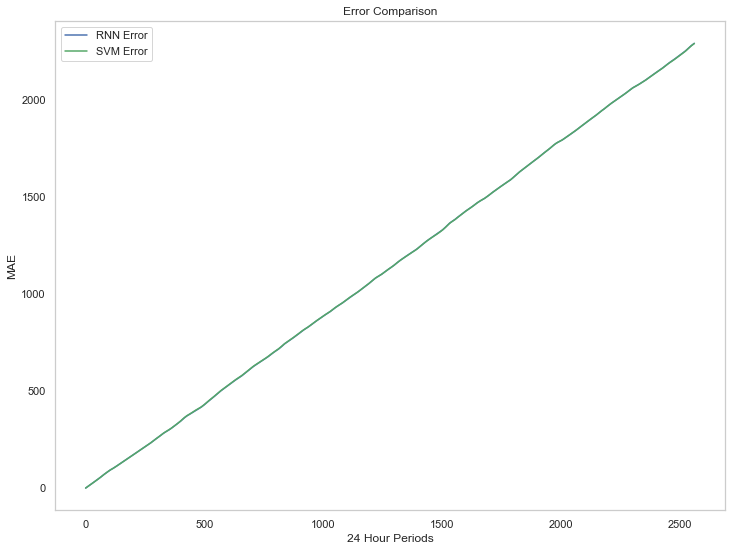

In [202]:
dates = np.arange(0,2560)

plt.plot(dates, rnn_batch_mae.cumsum(), color = 'b', label='RNN Error')
plt.plot(dates, svm_batch_mae.cumsum(), color = 'g', label='SVM Error')

plt.xlabel('24 Hour Periods')
plt.ylabel('MAE')
plt.title('Error Comparison')
plt.legend()
plt.show()

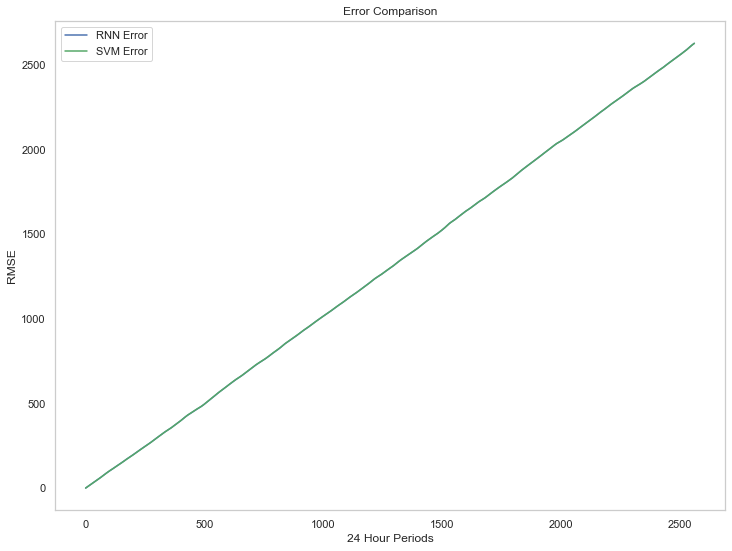

In [203]:
dates = np.arange(0,2560)

plt.plot(dates, rnn_batch_rmse.cumsum(), color = 'b', label='RNN Error')
plt.plot(dates, svm_batch_rmse.cumsum(), color = 'g', label='SVM Error')

plt.xlabel('24 Hour Periods')
plt.ylabel('RMSE')
plt.title('Error Comparison')
plt.legend()
plt.show()

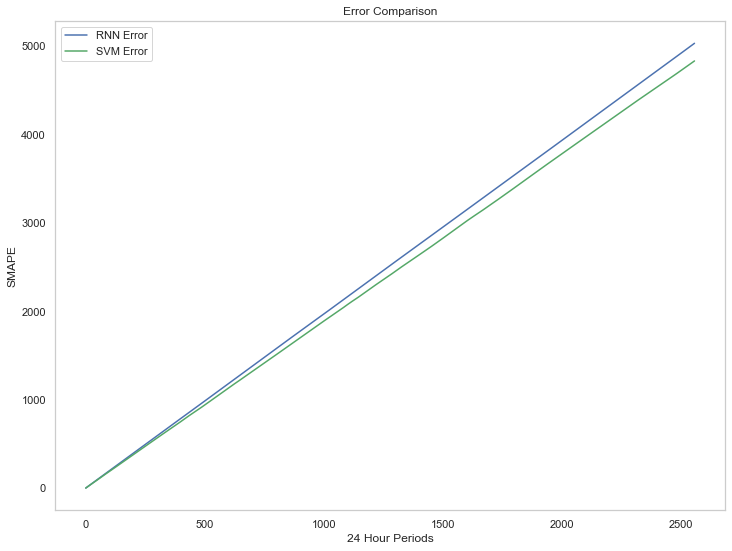

In [204]:
dates = np.arange(0,2560)

plt.plot(dates, rnn_batch_smape.cumsum(), color = 'b', label='RNN Error')
plt.plot(dates, svm_batch_smape.cumsum(), color = 'g', label='SVM Error')

plt.xlabel('24 Hour Periods')
plt.ylabel('SMAPE')
plt.title('Error Comparison')
plt.legend()
plt.show()

In [205]:
svmBars = [np.mean(svm_batch_mae), np.mean(svm_batch_rmse)]
rnnBars = [np.mean(rnn_batch_mae), np.mean(rnn_batch_rmse)]

groupedBarErrorData = np.array([["SVM", "MAE", np.mean(svm_batch_mae)],
                                ["SVM","RMSE", np.mean(svm_batch_rmse)], 
                                ["SVM", "SMAPE", np.mean(svm_batch_smape)], 
                                ["RNN", "MAE", np.mean(rnn_batch_mae)],
                                ["RNN", "RMSE", np.mean(rnn_batch_rmse)],
                                ["RNN", "SMAPE", np.mean(rnn_batch_smape)]
                               ])

In [206]:
groupedBarErrorDataFrame = pd.DataFrame(groupedBarErrorData, columns=["Model", "Metric", "Accuracy"])

groupedBarErrorDataFrame.head(10)

,Model,Metric,Accuracy
0,SVM,MAE,0.8956230931570813
1,SVM,RMSE,1.025906716172793
2,SVM,SMAPE,1.8880432313721933
3,RNN,MAE,0.896058657259057
4,RNN,RMSE,1.0260106935427646
5,RNN,SMAPE,1.9659683385421824


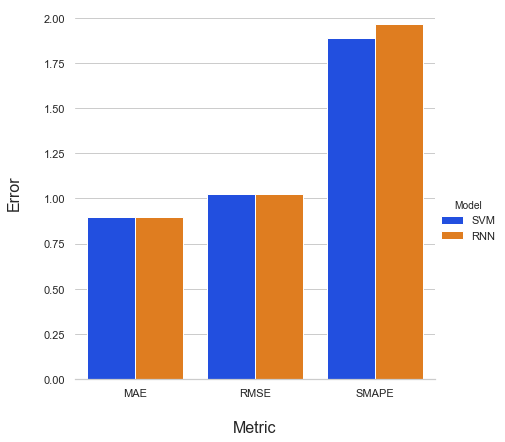

In [207]:
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="Metric", y="Accuracy", hue="Model", data=groupedBarErrorDataFrame,
                height=6, kind="bar", palette="bright")
g.despine(left=True)
g.set_ylabels("Error\n", fontsize = 16)
g.set_xlabels("\nMetric", fontsize = 16)